# Imports

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, norm, chi2
from statsmodels.stats.multitest import multipletests

## Import Functions

In [2]:
from src.K_Means_optimisation_GenePy import KM_opt, PCA_opt, KM, KM_RF, merge_phen_genepy
from src.cluster_enrichment_analysis import analyze_cluster_deviations
from src.Plotting import plotk

## Import SPARC IBD CADD15 GenePy Matrix

In [3]:
#Import SPARC IBD CADD15 GenePy matrix
SPARC_IBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/IBD Plexus/GenePy/ibdplexus202407_ccds_CADD15_merged.mmScaled.matrix")

#Set samid as index
SPARC_IBD_CADD15_GenePy = SPARC_IBD_CADD15_GenePy.set_index("samid")

## Import Southampton IBD CADD15 GenePy Matrix

In [4]:
# Import Soton Local IBD CADD15 GenePy matrix
dtype_dict = {"Gender": "object", "Age at diagnosis": "float64",
              'Diagnosis': "object", "Stricturing": "object", "Fistulating": "object",
              'Granuloma': "object", 'IBD Surgery': 'int64', 'IBD phenotype': 'object'}
#SotonIBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Soton Local IBD/jcDec24_CADD15_merged.mmScaled.matrix", dtype=dtype_dict)
SotonIBD_CADD15_GenePy = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/IBD Data/Soton Local IBD/GenePy/jcDec24_IBD_CADD15_merged.mmScaled.matrix", dtype=dtype_dict)

#Set samid as index
SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy.set_index("Samid")

SotonIBD_CADD15_GenePy = SotonIBD_CADD15_GenePy[SotonIBD_CADD15_GenePy['Diagnosis'] != "NOT_IBD"]

## Import Gene Lists

In [5]:
NOD_sig_genes9 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes9.txt")
NOD_sig_genes43 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NOD_sig_genes43.txt")
JAK_STAT_sig_genes_30 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/JAK_STAT_sig_genes30.txt")
IL10_sig_genes_49 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL10_sig_genes49.txt")
IL23_sig_genes_20 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/IL23_genes20.txt")
Th17_sig_genes_11 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/Th17_genes11.txt") #All of these genes are in the list of 20 IL-23 signalling genes
NADPH_genes_12 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes12.txt")
NADPH_genes_36 = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Gene lists/NADPH_sig_genes36.txt")

In [6]:
NOD2_gene = NOD_sig_genes9.loc[NOD_sig_genes9['Gene name'] == 'NOD2',:]

### IBD Consensus Pathways

In [7]:
IBD_consensus_paths = pd.read_table("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Progression Reviews/Confirmation Progression Review/Supp material/Consensus IBD pathway genes.txt")
IBD_union_genes = IBD_consensus_paths.loc[(IBD_consensus_paths['NOD signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-10 signalling consensus 2'] == 1) | (IBD_consensus_paths['IL-23 signalling consensus 2'] == 1) |
(IBD_consensus_paths['Th17 differentiation consensus 2']) | (IBD_consensus_paths['JAK-STAT consensus 2'] == 1) | (IBD_consensus_paths['NADPH oxidases consensus 2'] == 1),:]
IBD_union_genes = IBD_union_genes.iloc[:,list(range(0,4)) + [11] + [13] + [15] +[17] + [19] + [21]]
IBD_union_genes.loc[IBD_union_genes['Gene name'] == 'NOXO1', 'Gene stable ID'] = "ENSG00000196408"

In [8]:
IBD_union_genes['GenePy gene'] = IBD_union_genes['Gene stable ID'] + "_" + IBD_union_genes['Gene name'] + "_CADD15_matrix"
IBD_union_genes_sparc = IBD_union_genes.loc[:,['Gene stable ID', 'Gene name', 'GenePy gene']]

# SPARC IBD

## NOD2

In [8]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD2_gene, 50, cohort_name='SPARC')

In [9]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.794094,0.451358,1928
1,3,0.887133,0.423644,1928
2,4,0.906167,0.374828,1928
3,5,0.906751,0.354442,1928
4,6,0.890960,0.427247,1928
5,7,0.903515,0.391095,1928
6,8,0.933132,0.353009,1928
7,9,0.943545,0.331536,1928
8,10,0.944424,0.368829,1928
9,11,0.944724,0.347718,1928


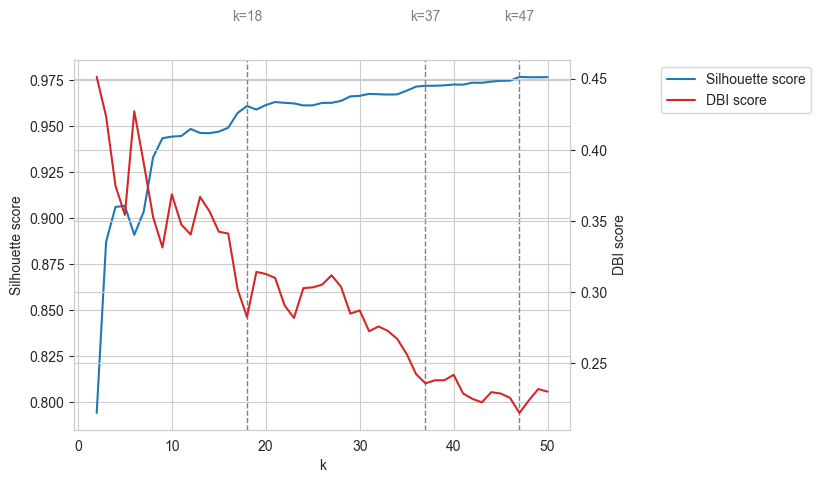

In [15]:
plotk(results_df, [18,37, 47])

In [29]:
#k = 18
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD2_gene, 47)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [17]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_NOD2_18C_genepy.txt", sep='\t', index=False)

In [30]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

1.6769423097558974e-19
8.389548336853851e-14
6.340267053659577e-08


In [25]:
results_df['IBD surgery final']['corr_p_values_chi2'] #.keys()

IBD surgery final,0.0,1.0
0,0.438799,0.438799
1,0.164184,0.130950
4,0.709595,0.661108
5,0.438799,0.438799
6,0.438799,0.438799
7,0.626175,0.582754
8,0.367779,0.211918
11,0.196453,0.130950
12,0.939682,0.939682
15,0.438799,0.438799


In [23]:
results_df['Diagnosis']['residuals']

Diagnosis,CD,UC
0,1.764935,-2.554413
1,-3.055359,4.422059
2,-0.529767,0.766739
4,0.627730,-0.908522
5,1.545031,-2.236142
7,1.194339,-1.728582
8,1.355666,-1.962072
11,2.217655,-3.209639
15,1.315223,-1.903538
17,0.701093,-1.014701


## 9 NOD Signalling Genes

In [9]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='SPARC')

In [12]:
#results_df

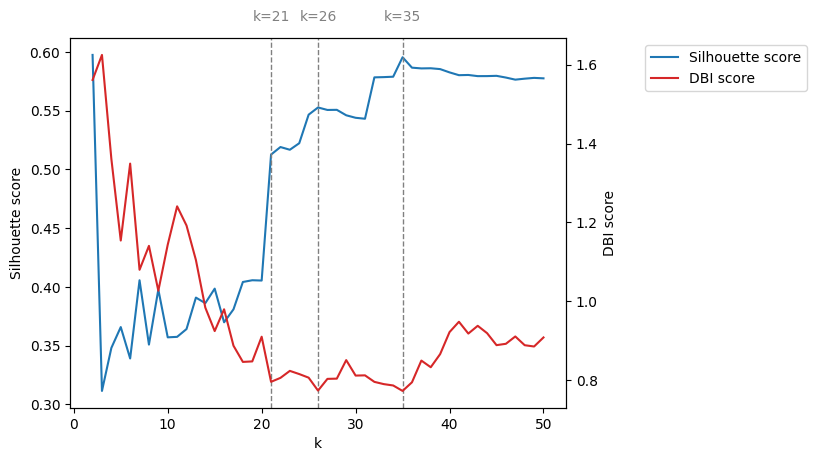

In [10]:
plotk(results_df, [21, 26, 35])

### K = 35

In [12]:
#For k = 21, silhouette score is 0.5126 and the DBI score is 0.8283
#k = 15; silhouette score = 0.398559; DBI = 0.923939
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes9, 35)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [16]:
km_out_phen_GenePy

,Samid,Cluster,Sex,Diagnosis,Age at diagnosis,Crohn s disease phenotype,IBD surgery final,ENSG00000064012_CASP8_CADD15_matrix,ENSG00000104312_RIPK2_CADD15_matrix,ENSG00000104365_IKBKB_CADD15_matrix,ENSG00000106100_NOD1_CADD15_matrix,ENSG00000137752_CASP1_CADD15_matrix,ENSG00000167207_NOD2_CADD15_matrix,ENSG00000187796_CARD9_CADD15_matrix,ENSG00000213341_CHUK_CADD15_matrix,ENSG00000269335_IKBKG_CADD15_matrix
0,10150028,8,Female,UC,70.0,"Inflammatory non-penetrating, non-stricturing ...",0.0,0.041214,0.175602,0.0,0.127193,0.0,0.000000,0.0,0.093488,0.000000
1,10150030,8,Female,CD,15.0,Both stricturing and penetrating (B2B3),1.0,0.041214,0.175602,0.0,0.000000,0.0,0.000000,0.0,0.097048,0.000000
2,10150035,20,Female,CD,10.0,Stricturing (B2),1.0,0.092827,0.000000,0.0,0.000000,0.0,0.132311,0.0,0.000000,0.500151
3,10150036,8,Female,CD,26.0,Both stricturing and penetrating (B2B3),NaN,0.092827,0.175602,0.0,0.076267,0.0,0.000000,0.0,0.000000,0.000000
4,10150186,4,Male,CD,37.0,Penetrating (B3),NaN,0.092827,0.000000,0.0,0.076267,0.0,0.493085,0.0,0.097048,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,9649776,7,Female,CD,12.0,Penetrating (B3),NaN,0.092827,0.000000,0.0,0.127193,0.0,0.000000,0.0,0.097048,0.000000
2856,9650147,8,Male,UC,38.0,"Inflammatory non-penetrating, non-stricturing ...",0.0,0.092827,0.175602,0.0,0.076267,0.0,0.000000,0.0,0.093488,0.000000
2857,9650172,23,Female,CD,55.0,Stricturing (B2),NaN,0.092827,0.000000,0.0,0.000000,0.0,0.172726,0.0,0.093488,0.000000
2858,9748952,24,Female,CD,13.0,Penetrating (B3),0.0,0.041214,0.000000,0.0,0.076267,0.0,0.000000,0.0,0.093488,0.000000


In [17]:
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_9F_35C_NOD_2_genepy.txt", sep='\t', index=False)

In [18]:
feat_imp = KM_RF(km_out, X)

In [19]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [22]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp[feat_imp['Feature'] == "ENSG00000167207_NOD2_CADD15_matrix"].sort_values(by="Importance", ascending=False)

,Feature,Importance,Cluster
198,ENSG00000167207_NOD2_CADD15_matrix,0.969022,22
36,ENSG00000167207_NOD2_CADD15_matrix,0.882754,4
225,ENSG00000167207_NOD2_CADD15_matrix,0.743533,25
252,ENSG00000167207_NOD2_CADD15_matrix,0.698286,28
126,ENSG00000167207_NOD2_CADD15_matrix,0.622025,14
207,ENSG00000167207_NOD2_CADD15_matrix,0.579528,23
0,ENSG00000167207_NOD2_CADD15_matrix,0.570331,0
171,ENSG00000167207_NOD2_CADD15_matrix,0.556449,19
9,ENSG00000167207_NOD2_CADD15_matrix,0.553375,1
189,ENSG00000167207_NOD2_CADD15_matrix,0.491586,21


In [184]:
feat_imp[feat_imp['Cluster'] == 32].sort_values(by="Importance", ascending=False)

,Feature,Importance,Cluster
288,ENSG00000064012_CASP8_CADD15_matrix,0.463964,32
289,ENSG00000187796_CARD9_CADD15_matrix,0.347574,32
290,ENSG00000167207_NOD2_CADD15_matrix,0.124885,32
291,ENSG00000106100_NOD1_CADD15_matrix,0.045763,32
292,ENSG00000213341_CHUK_CADD15_matrix,0.017374,32
293,ENSG00000104312_RIPK2_CADD15_matrix,0.000252,32
294,ENSG00000269335_IKBKG_CADD15_matrix,0.000148,32
295,ENSG00000104365_IKBKB_CADD15_matrix,0.000039,32
296,ENSG00000137752_CASP1_CADD15_matrix,0.000000,32


In [178]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 20]['ENSG00000269335_IKBKG_CADD15_matrix'].value_counts()

ENSG00000269335_IKBKG_CADD15_matrix
0.500151    11
Name: count, dtype: int64

In [179]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 20]['Diagnosis'].value_counts()

Diagnosis
CD    7
UC    4
Name: count, dtype: int64

In [172]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 17) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['Crohn s disease phenotype'].value_counts()

Crohn s disease phenotype
Inflammatory non-penetrating, non-stricturing (B1)    4
Unknown                                               2
Stricturing (B2)                                      2
Name: count, dtype: int64

In [118]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

Diagnosis  Crohn s disease phenotype                           IBD surgery final
CD         Inflammatory non-penetrating, non-stricturing (B1)  0.0                  7
           Penetrating (B3)                                    1.0                  6
UC         Inflammatory non-penetrating, non-stricturing (B1)  0.0                  5
CD         Stricturing (B2)                                    1.0                  4
           Inflammatory non-penetrating, non-stricturing (B1)  1.0                  3
           Both stricturing and penetrating (B2B3)             1.0                  3
           Unknown                                             0.0                  3
                                                               1.0                  3
Name: count, dtype: int64

In [116]:
#Check raw and multiple-test-corrected p-values
results_df['Diagnosis']['p_values_chi2']#.keys()

Diagnosis,CD,UC
0,0.431096,0.254497
1,0.628672,0.483980
2,0.451604,0.275953
3,0.951561,0.929940
4,0.202722,0.065236
5,0.537640,0.372338
6,0.951561,0.929940
7,0.586720,0.431427
8,0.086183,0.013013
9,0.984815,0.978024


In [ ]:
#Cluster 22 (n = 33)
#NOD2 -> 96.9%; GenePy >= 0.614532
#

### K = 21

In [13]:
feat_imp = KM_RF(km_out, X)

In [18]:
feat_imp[feat_imp['Cluster'] == 7].sort_values(by='Importance', ascending=False)

In [14]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [15]:
results_df['Diagnosis']['corr_p_values_chi2']#.keys()

Diagnosis,CD,UC
0,0.659830,0.508994
1,0.761370,0.681840
2,0.670954,0.512484
3,0.984815,0.984815
4,0.479162,0.326717
5,0.716853,0.624567
6,0.984815,0.984815
7,0.744133,0.659830
8,0.326717,0.150806
9,0.984815,0.984815


In [11]:
#Cluster 14 - enriched for CD and depleted for UC
#193 CD/UC patients with NOD2 GenePy within 0.2607 to 0.4545, RIPK2 GenePy =< 0.1756 (192 have a score of 0) and NOD1 within 0 and 0.394107
SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.454504) &
                                             (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.394107)).astype(int)

# SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207.15_NOD2'] <= 0.454504) &
#                                               (SotonIBD_CADD15_GenePy['ENSG00000104312.8_RIPK2'] <= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000106100.11_NOD1'] <= 0.394107)).astype(int)

C:\Users\fvl1g23\AppData\Local\Temp\ipykernel_2980\1725620441.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  SotonIBD_CADD15_GenePy['cluster 14'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.260743) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.454504) &


In [61]:
#Cluster 19 is depleted for UC (n = 113)
#NOD2 (47.15%) -> 0.132311-0.406112
#RIPK2 (46.16%) -> 0.175602-0.490679
#NOD1 (2.1369%) -> <= 0.127193
SotonIBD_CADD15_GenePy['cluster 19'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311) &
                                               (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.406112) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) &
                                               #(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679) &
                                              (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.127193)).astype(int)

In [66]:
#Cluster 4 is depleted for UC
#NOD2 (96.76%) -> >= 0.732
SotonIBD_CADD15_GenePy['cluster 4'] = (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.732).astype(int)

C:\Users\fvl1g23\AppData\Local\Temp\ipykernel_24392\4147660187.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  SotonIBD_CADD15_GenePy['cluster 4'] = (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.732).astype(int)


In [69]:
#Cluster 12 -> 357 patients with NOD2 0 and CHUK 0, RIPK2 0
SotonIBD_CADD15_GenePy['cluster 12'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000213341_CHUK'] == 0)
                                            & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] == 0)).astype(int)

C:\Users\fvl1g23\AppData\Local\Temp\ipykernel_24392\2963560684.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  SotonIBD_CADD15_GenePy['cluster 12'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000213341_CHUK'] == 0)


In [60]:
SotonIBD_CADD15_GenePy.loc[(SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] >= 0.175602) & (SotonIBD_CADD15_GenePy['ENSG00000104312_RIPK2'] <= 0.490679),:].value_counts("ENSG00000104312_RIPK2")

ENSG00000104312_RIPK2
0.192665    170
0.372367      8
Name: count, dtype: int64

In [12]:
cont_table = pd.crosstab(SotonIBD_CADD15_GenePy['cluster 14'], SotonIBD_CADD15_GenePy['Diagnosis'])
#Remove IBDU
cont_table = cont_table.iloc[:,[0,3]]
#chi square
chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
p_value

np.float64(0.0028791777781077632)

In [13]:
cont_table

Diagnosis,CD,UC
cluster 14,,
0,705,397
1,48,9


In [14]:
#Calculate standardised residuals
residuals = (cont_table - expected) / np.sqrt(expected)

#Two-tailed t-tests for each cell
p_values_matrix = 2 * (1 - norm.cdf(abs(residuals)))

#Multple test correction with Bejamini-Hochberg FDR
flat_p_values = p_values_matrix.flatten()
rejected, corrected_p_values, _, _ = multipletests(flat_p_values,
                                                 alpha=0.05,
                                                 method='fdr_bh')
corrected_p_values_matrix = corrected_p_values.reshape(p_values_matrix.shape)
corr_p_values_df = pd.DataFrame(
            corrected_p_values_matrix,
            index=cont_table.index,
            columns=cont_table.columns
        )

residuals_df = pd.DataFrame(
            residuals,
            index=cont_table.index,
            columns=cont_table.columns
        )

#Chi-square per cell contributions
cell_contributions = (cont_table - expected) ** 2 / expected
p_values_chi2 = 1 - chi2.cdf(cell_contributions, df=1)
flat_p_values_chi2 = p_values_chi2.flatten()
_, corrected_p_values_chi2, _, _ = multipletests(flat_p_values_chi2, alpha=0.05, method='fdr_bh')

corr_p_values_chi2_df = pd.DataFrame(corrected_p_values_chi2.reshape(p_values_chi2.shape),
                                      index=cont_table.index, columns=cont_table.columns)

In [22]:
#p_values_chi2
p_values_chi2
#corr_p_values_chi2_df

array([[0.68189883, 0.57671278],
       [0.07151388, 0.01411372]])

## 43 NOD Signalling Genes

In [9]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 50, cohort_name='SPARC')

In [93]:
#results_df

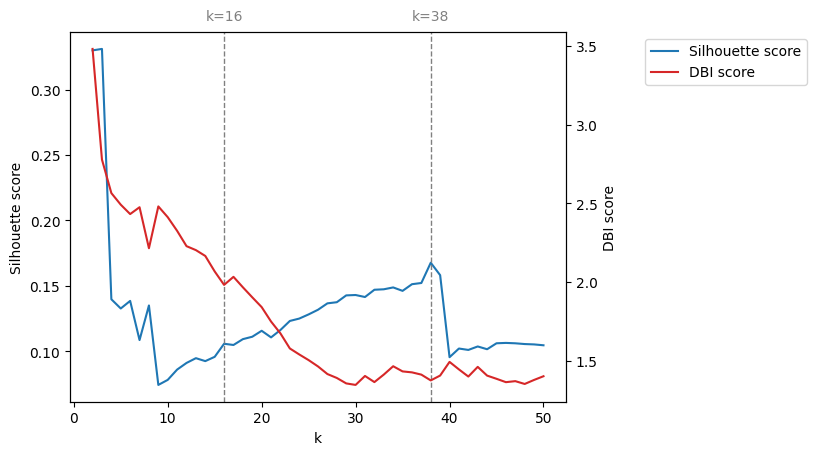

In [10]:
plotk(results_df, [16, 38])

In [86]:
# k = 16
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 16)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [37]:
#km_out.value_counts()

In [87]:
feat_imp = KM_RF(km_out, X)

In [31]:
feat_imp[feat_imp['Importance'] >= 0.1]['Feature'].unique()
#.sort_values(by='Importance', ascending=False)

array([np.str_('ENSG00000091592_NLRP1_CADD15_matrix'),
       np.str_('ENSG00000167207_NOD2_CADD15_matrix'),
       np.str_('ENSG00000100324_TAB1_CADD15_matrix'),
       np.str_('ENSG00000188130_MAPK12_CADD15_matrix'),
       np.str_('ENSG00000173039_RELA_CADD15_matrix'),
       np.str_('ENSG00000165416_SUGT1_CADD15_matrix'),
       np.str_('ENSG00000196954_CASP4_CADD15_matrix'),
       np.str_('ENSG00000187796_CARD9_CADD15_matrix'),
       np.str_('ENSG00000023445_BIRC3_CADD15_matrix'),
       np.str_('ENSG00000105483_CARD8_CADD15_matrix'),
       np.str_('ENSG00000106100_NOD1_CADD15_matrix'),
       np.str_('ENSG00000167634_NLRP7_CADD15_matrix'),
       np.str_('ENSG00000112851_ERBIN_CADD15_matrix'),
       np.str_('ENSG00000104312_RIPK2_CADD15_matrix'),
       np.str_('ENSG00000055208_TAB2_CADD15_matrix'),
       np.str_('ENSG00000064012_CASP8_CADD15_matrix')], dtype=object)

In [238]:
feat_imp[feat_imp['Cluster'] == 13]

,Feature,Importance,Cluster
559,ENSG00000167207_NOD2_CADD15_matrix,0.764124,13
560,ENSG00000112851_ERBIN_CADD15_matrix,0.020798,13
561,ENSG00000106100_NOD1_CADD15_matrix,0.018790,13
562,ENSG00000132906_CASP9_CADD15_matrix,0.016192,13
563,ENSG00000142405_NLRP12_CADD15_matrix,0.014166,13
564,ENSG00000188130_MAPK12_CADD15_matrix,0.013760,13
565,ENSG00000173039_RELA_CADD15_matrix,0.011753,13
566,ENSG00000132357_CARD6_CADD15_matrix,0.010708,13
567,ENSG00000213341_CHUK_CADD15_matrix,0.009627,13
568,ENSG00000196954_CASP4_CADD15_matrix,0.009217,13


In [90]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 10].value_counts("ENSG00000165416_SUGT1_CADD15_matrix")

ENSG00000165416_SUGT1_CADD15_matrix
0.201281    189
0.406106     14
0.444293      9
0.600906      1
0.771724      1
0.777546      1
0.899481      1
0.902879      1
1.000000      1
Name: count, dtype: int64

In [237]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 13].value_counts('Diagnosis', normalize=False)

Diagnosis
CD      104
UC       19
IBDU      2
Name: count, dtype: int64

In [82]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [83]:
results_df['Diagnosis']['corr_p_values_chi2']

Diagnosis,CD,UC
Cluster,,
0,0.997025,0.997025
1,0.019417,0.000365
2,0.997025,0.997025
3,0.997025,0.997025
4,0.997025,0.997025
5,0.070296,0.003720
6,0.997025,0.997025
7,0.997025,0.997025
8,0.997025,0.997025


In [84]:
results_df['Crohn s disease phenotype']['corr_p_values_chi2']

Crohn s disease phenotype,"Inflammatory non-penetrating, non-stricturing (B1)",Stricturing (B2),Penetrating (B3),Both stricturing and penetrating (B2B3)
1,0.025022,0.007323,0.230723,0.322422
3,0.605653,0.481051,0.701430,0.807533
5,0.088403,0.022073,0.287221,0.585440
10,0.481051,0.585440,0.585440,0.358596
13,0.241219,0.241219,0.764092,0.088403
Misc,0.585440,0.394646,0.481051,0.585440


In [169]:
results_df['IBD surgery final']['corr_p_values_chi2']

IBD surgery final,0.0,1.0
Cluster,,
0,0.995984,0.995984
1,0.037481,0.009675
2,0.815686,0.723623
3,0.929447,0.815686
4,0.997928,0.997928
5,0.204461,0.115864
6,0.995984,0.995984
7,0.272746,0.204461
8,0.995984,0.995984


In [278]:
km_out_phen_GenePy.loc[(km_out_phen_GenePy['Cluster'] == 13) & (km_out_phen_GenePy['Diagnosis'] != "IBDU"),:].value_counts("ENSG00000132357_CARD6_CADD15_matrix").sort_values(ascending=False)

ENSG00000132357_CARD6_CADD15_matrix
0.000000    87
0.088196    25
0.314479     3
0.230076     2
0.166177     1
0.141880     1
0.281668     1
0.333041     1
0.384468     1
0.456359     1
Name: count, dtype: int64

In [284]:
#Cluster 1
#NOD2 70.22% -> 0.1323 - 0.3652
#SUGT1 3.96% -> <= 0.2013
#ERBIN 2.67% ->  <= 0.3058
#MAPK12 2.09% -> <= 0.2843
#NOD1 1.75% -> <= 0.2768
#RELA 1.69% -> 0
#BIRC3 1.69% -> 0
#NLRP1 1.43% -> <= 0.2021
#CASP8 1.32% -> <= 0.09
SotonIBD_CADD15_GenePy['Cluster 1'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.132311468176971) & (SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] <= 0.365205488832726)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.201280690665366) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.375835188227294)&
                                       (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123) & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.276787154268017) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0) &
                                       (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)).astype(int)

In [232]:
#Cluster 5
#NOD2 46.21% -> 0
#SUGT1 13.83% -> <= 0.007
#ERBIN 5.16% -> <= 0.3254
#MAPK12 4.22% -> <= 0.2843
#NOD1 3.65% -> <= 0.3178
#RELA 3.59% -> 0
#NRLP1 3.15% -> <= 0.2021
#CARD9 2.84% -> 0
#BIRC3 2.31% -> 0
#TAB1 2.12% -> 0
#CARD8 1.77% -> 0
#NLRP7 1.31% -> 0
SotonIBD_CADD15_GenePy['Cluster 5'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] == 0) & (SotonIBD_CADD15_GenePy['ENSG00000165416_SUGT1'] <= 0.0070120773143289)
                                       & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.325406754325555)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.284265744209123)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.317840326123237) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] == 0)
#                                       & (SotonIBD_CADD15_GenePy['ENSG00000091592_NLRP1'] <= 0.202101747859509)&(SotonIBD_CADD15_GenePy['ENSG00000187796_CARD9'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000023445_BIRC3'] == 0)& (SotonIBD_CADD15_GenePy['ENSG00000100324_TAB1'] == 0) &
#                                       (SotonIBD_CADD15_GenePy['ENSG00000105483_CARD8'] == 0)
                                       ).astype(int)

In [280]:
#Cluster 13
#NOD2 76.41% -> >= 0.3585
#ERBIN 2.08% -> <= 0.5793
#NOD1 1.88% -> <= 0.5118
#CASP9 1.62% -> <= 0.6922
#NLRP12 1.42% <= 0.4622
#MAPK12 1.37% -> <= 0.44
#RELA 1.17% -> <= 0.4136
#CARD6 1.07% -> <= 0.4563
SotonIBD_CADD15_GenePy['Cluster 13'] = ((SotonIBD_CADD15_GenePy['ENSG00000167207_NOD2'] >= 0.358468103620945) & (SotonIBD_CADD15_GenePy['ENSG00000112851_ERBIN'] <= 0.579367065203214) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000106100_NOD1'] <= 0.511821245992663) & (SotonIBD_CADD15_GenePy['ENSG00000132906_CASP9'] <= 0.692219162925112)
                                        & (SotonIBD_CADD15_GenePy['ENSG00000142405_NLRP12'] <= 0.462179899117249)&
                                        (SotonIBD_CADD15_GenePy['ENSG00000188130_MAPK12'] <= 0.442011527819315) & (SotonIBD_CADD15_GenePy['ENSG00000173039_RELA'] <= 0.41358255389904) &
                                        (SotonIBD_CADD15_GenePy['ENSG00000132357_CARD6'] <= 0.456358576821125)
                                        ).astype(int)

In [294]:
cont_table = pd.crosstab(SotonIBD_CADD15_GenePy['Cluster 1'], SotonIBD_CADD15_GenePy['IBD Surgery'])
#Remove IBDU
#cont_table = cont_table.iloc[:,[0,3]]
#chi square
chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
p_value

np.float64(0.214029844301585)

In [295]:
cont_table

IBD Surgery,0,1
Cluster 1,,
0,696,336
1,111,67


In [296]:
#Calculate standardised residuals
residuals = (cont_table - expected) / np.sqrt(expected)

#Two-tailed t-tests for each cell
p_values_matrix = 2 * (1 - norm.cdf(abs(residuals)))

#Multple test correction with Bejamini-Hochberg FDR
flat_p_values = p_values_matrix.flatten()
rejected, corrected_p_values, _, _ = multipletests(flat_p_values,
                                                 alpha=0.05,
                                                 method='fdr_bh')
corrected_p_values_matrix = corrected_p_values.reshape(p_values_matrix.shape)
corr_p_values_df = pd.DataFrame(
            corrected_p_values_matrix,
            index=cont_table.index,
            columns=cont_table.columns
        )

residuals_df = pd.DataFrame(
            residuals,
            index=cont_table.index,
            columns=cont_table.columns
        )

#Chi-square per cell contributions
cell_contributions = (cont_table - expected) ** 2 / expected
p_values_chi2 = 1 - chi2.cdf(cell_contributions, df=1)
flat_p_values_chi2 = p_values_chi2.flatten()
_, corrected_p_values_chi2, _, _ = multipletests(flat_p_values_chi2, alpha=0.05, method='fdr_bh')

corr_p_values_chi2_df = pd.DataFrame(corrected_p_values_chi2.reshape(p_values_chi2.shape),
                                      index=cont_table.index, columns=cont_table.columns)
corr_p_values_chi2_df

IBD Surgery,0,1
Cluster 1,,
0,0.768683,0.768683
1,0.768683,0.768683


In [8]:
# k = 38
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NOD_sig_genes43, 38)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [52]:
km_out.value_counts()

Cluster
21         742
1          248
32         168
16         152
5          144
4          103
10         102
15          94
12          83
11          72
31          71
29          66
18          48
23          45
17          44
9           44
33          44
8           43
28          42
0           41
2           40
27          39
7           39
25          36
20          31
14          31
3           30
26          29
30          28
13          26
35          24
22          22
6           20
34          19
24          18
37          12
19          11
36           9
Name: count, dtype: int64

In [9]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [12]:
results_df['Crohn s disease phenotype']['overall_p_value']

np.float64(2.5160205288997273e-10)

In [10]:
results_df['Diagnosis'].keys()

dict_keys(['observed', 'expected', 'chi2_stat', 'overall_p_value', 'residuals', 'p_values', 'corr_p_values', 'formatted', 'chi2_contributions', 'p_values_chi2', 'corr_p_values_chi2'])

## Other Pathways

In [47]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 50, cohort_name='SPARC')

In [48]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.446587,1.279111,2808
1,3,0.095772,2.677420,1763
2,4,0.110593,2.569477,1740
3,5,0.124682,2.258701,2146
4,6,0.132334,2.059595,2124
5,7,0.136844,1.962658,2018
6,8,0.085927,2.045960,1190
7,9,0.090537,1.894317,1174
8,10,0.094067,1.797808,1145
9,11,0.084877,1.943512,878


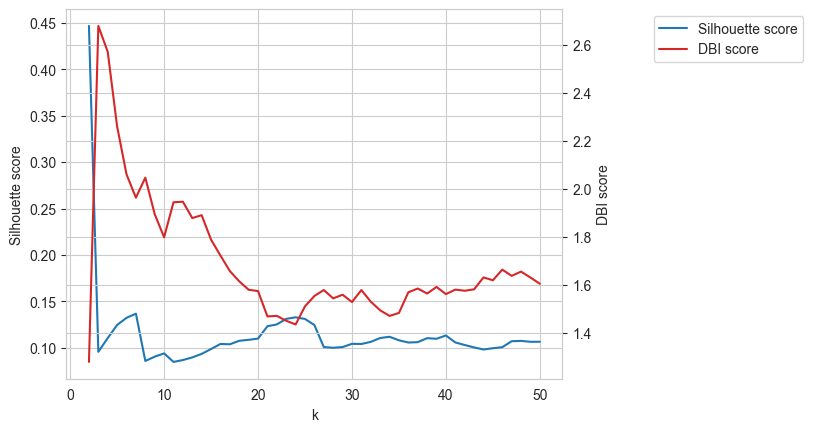

In [49]:
plotk(results_df)

In [50]:
#k = 32
km_out, X = KM(SPARC_IBD_CADD15_GenePy, NADPH_genes_36, 24)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)


In [15]:
#km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/SPARC_KMeans_30F_32C_JAK_STAT_genepy.txt", sep='\t', index=False)

In [51]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])
print(results_df['Diagnosis']['overall_p_value'])
print(results_df['Crohn s disease phenotype']['overall_p_value'])
print(results_df['IBD surgery final']['overall_p_value'])

0.9158097682929938
0.4107206530554169
0.6987264898576018


## 34 Consensus IBD Genes

In [13]:
results_df = KM_opt(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 50, cohort_name='SPARC')

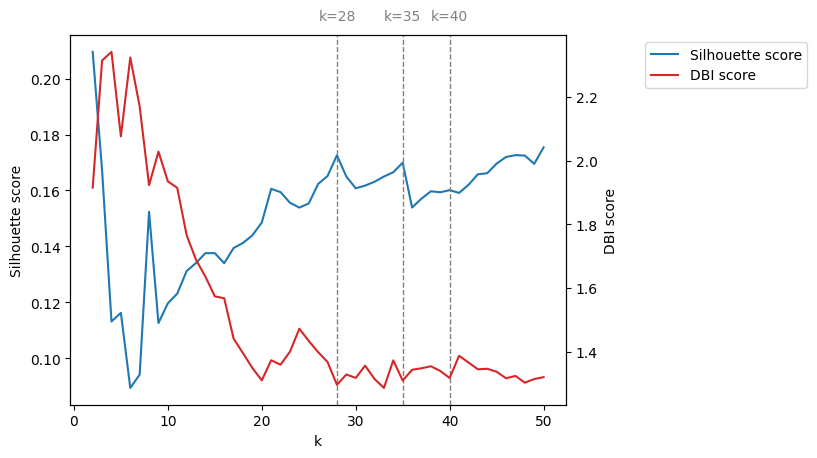

In [14]:
plotk(results_df, [28, 35, 40])

In [7]:
# k = 40
km_out, X = KM(SPARC_IBD_CADD15_GenePy, IBD_union_genes_sparc, 40)
km_out_phen_GenePy = merge_phen_genepy(km_out, SPARC_IBD_CADD15_GenePy, X)

In [80]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 17].value_counts('Crohn s disease phenotype', normalize=True)

Crohn s disease phenotype
Inflammatory non-penetrating, non-stricturing (B1)    0.741935
Unknown                                               0.161290
Stricturing (B2)                                      0.064516
Penetrating (B3)                                      0.032258
Name: proportion, dtype: float64

In [66]:
km_out_phen_GenePy.value_counts('Crohn s disease phenotype', normalize=True)

Crohn s disease phenotype
Inflammatory non-penetrating, non-stricturing (B1)    0.602797
Stricturing (B2)                                      0.144406
Unknown                                               0.107343
Penetrating (B3)                                      0.089860
Both stricturing and penetrating (B2B3)               0.055594
Name: proportion, dtype: float64

In [8]:
feat_imp = KM_RF(km_out, X)

In [9]:
#len(feat_imp[feat_imp['Importance'] >= 0.1]['Feature'].unique())
feat_imp[feat_imp['Cluster'] == 22]

,Feature,Importance,Cluster
726,ENSG00000196408_NOXO1_CADD15_matrix,0.452221,22
727,ENSG00000167207_NOD2_CADD15_matrix,0.288663,22
728,ENSG00000116701_NCF2_CADD15_matrix,0.040784,22
729,ENSG00000105397_TYK2_CADD15_matrix,0.034285,22
730,ENSG00000106100_NOD1_CADD15_matrix,0.030421,22
731,ENSG00000213341_CHUK_CADD15_matrix,0.026211,22
732,ENSG00000064012_CASP8_CADD15_matrix,0.023516,22
733,ENSG00000051523_CYBA_CADD15_matrix,0.021059,22
734,ENSG00000185386_MAPK11_CADD15_matrix,0.016101,22
735,ENSG00000104312_RIPK2_CADD15_matrix,0.010307,22


In [47]:
results_chi2 = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'Crohn s disease phenotype', 'IBD surgery final'])

In [48]:
results_chi2['Diagnosis']['p_values_chi2']

Diagnosis,CD,UC
1,0.095097,0.015704
2,0.080041,0.011295
3,0.988541,0.983416
4,0.781796,0.688511
5,0.977487,0.967421
6,0.625005,0.479317
7,0.457862,0.282624
8,0.635131,0.492224
9,0.403105,0.226247
10,0.169324,0.046684


In [49]:
results_chi2['Diagnosis']['residuals']

Diagnosis,CD,UC
1,-1.669105,2.415716
2,1.750446,-2.533442
3,-0.014363,0.020787
4,-0.276980,0.400876
5,0.028220,-0.040843
6,-0.488769,0.707401
7,0.742372,-1.074444
8,0.474518,-0.686775
9,-0.836089,1.210082
10,-1.374381,1.989158


In [29]:
results_chi2['Crohn s disease phenotype']['p_values_chi2']

Crohn s disease phenotype,"Inflammatory non-penetrating, non-stricturing (B1)",Stricturing (B2),Penetrating (B3),Both stricturing and penetrating (B2B3)
1,0.327819,0.036379,0.819286,0.888764
2,0.021755,0.046231,0.019941,0.166284
9,0.612896,0.420452,0.815922,0.942917
10,0.722155,0.545780,0.887690,0.706310
11,0.216363,0.668800,0.126354,0.150468
18,0.173988,0.502866,0.326534,0.031598
19,0.272513,0.338412,0.702299,0.113102
21,0.911377,0.545511,0.953814,0.593254
22,0.150407,0.045311,0.952855,0.113102
23,0.135358,0.090747,0.569031,0.142348


In [37]:
results_chi2['Crohn s disease phenotype']['residuals']

Crohn s disease phenotype,"Inflammatory non-penetrating, non-stricturing (B1)",Stricturing (B2),Penetrating (B3),Both stricturing and penetrating (B2B3)
1,0.978516,-2.092663,0.228464,-0.139868
2,-2.294610,1.993278,2.327450,1.384243
9,0.505944,-0.805637,-0.232793,-0.071604
10,0.355581,-0.604096,0.141228,-0.376817
11,-1.236258,0.427796,1.528639,1.437882
18,1.359501,-0.669987,-0.981119,-2.149462
19,-1.097293,0.957308,0.382218,1.584404
21,0.111301,-0.604501,0.057918,0.534126
22,-1.438095,2.001755,-0.059122,1.584404
23,-1.493304,1.691469,0.569479,1.467102


In [32]:
results_chi2['IBD surgery final']['p_values_chi2']

IBD surgery final,0.0,1.0
0,0.886318,0.865199
1,0.585786,0.517576
2,0.162861,0.097508
3,0.410454,0.328392
4,0.878557,0.856025
5,0.440325,0.359528
6,0.183641,0.114376
7,0.989221,0.987201
8,0.901010,0.882582
9,0.705075,0.653134


In [25]:
results_chi2['Diagnosis'].keys()

dict_keys(['observed', 'expected', 'chi2_stat', 'overall_p_value', 'residuals', 'p_values', 'corr_p_values', 'formatted', 'chi2_contributions', 'p_values_chi2', 'corr_p_values_chi2'])

# Southampton IBD

## 9 NOD Signalling Genes

In [194]:
results_df = KM_opt(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 50, cohort_name='Soton')

In [195]:
results_df

,n_clusters,silhouette_score,DBI_score,max_cluster_size
0,2,0.457878,0.954722,1114
1,3,0.233213,1.635916,689
2,4,0.241413,1.323597,684
3,5,0.268346,1.282749,582
4,6,0.276965,1.100572,577
5,7,0.250395,1.180839,458
6,8,0.307866,0.996812,475
7,9,0.316084,0.917835,471
8,10,0.314914,0.935670,471
9,11,0.334571,0.855272,465


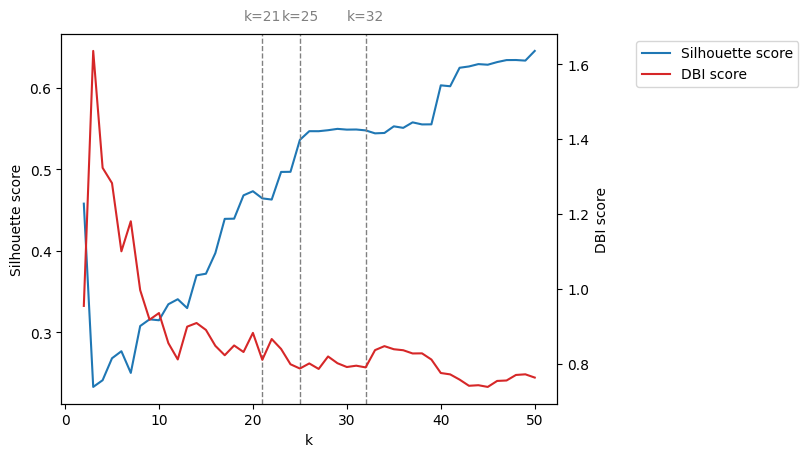

In [198]:
plotk(results_df,[21, 25, 32])

### K = 32

In [233]:
#k = 32
km_out, X = KM(SotonIBD_CADD15_GenePy, NOD_sig_genes9, 32, "Soton")
km_out_phen_GenePy = merge_phen_genepy(km_out, SotonIBD_CADD15_GenePy, X, "Soton")
km_out_phen_GenePy.to_csv("C:/Users/fvl1g23/OneDrive - University of Southampton/PhD/Projects/ML/Unsupervised ML/K-Means cluster enrichment analysis/K-Means output/Soton_KMeans_9F_32C_NOD_2_genepy.txt", sep='\t', index=False)

In [235]:
km_out_phen_GenePy

,Samid,Cluster,Gender,Age at diagnosis,Diagnosis,Stricturing,Fistulating,Granuloma,IBD Surgery,IBD phenotype,ENSG00000064012.24_CASP8,ENSG00000104312.8_RIPK2,ENSG00000104365.16_IKBKB,ENSG00000106100.11_NOD1,ENSG00000137752.25_CASP1,ENSG00000167207.15_NOD2,ENSG00000187796.16_CARD9,ENSG00000213341.11_CHUK,ENSG00000269335.7_IKBKG
0,AP0013,24,F,18.000000,CD,NaN,NaN,NaN,0,NaN,0.098336,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.000000,0
1,AP0030,20,F,20.000000,CD,NaN,NaN,NaN,0,NaN,0.098336,0.000000,0.0,0.081846,0.0,0.108142,0.0,0.088421,0
2,AP0045,2,M,44.000000,UC,NaN,NaN,NaN,0,NaN,0.043660,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.085177,0
3,AP0046,2,F,43.000000,UC,NaN,NaN,NaN,0,NaN,0.043660,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.088421,0
4,AP0065,2,F,12.000000,UC,NaN,NaN,NaN,0,NaN,0.098336,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.085177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,SORL0039,8,F,13.000000,CD,NaN,NaN,NaN,0,NaN,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.085177,0
1283,SORL0040,2,F,66.000000,UC,NaN,NaN,NaN,0,NaN,0.000000,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.085177,0
1284,SORL0041,2,F,19.000000,UC,NaN,NaN,NaN,0,NaN,0.043660,0.000000,0.0,0.081846,0.0,0.000000,0.0,0.088421,0
1285,SORL0050,14,F,16.704110,NaN,NaN,NaN,NaN,0,NaN,0.043660,0.000000,0.0,0.081846,0.0,0.604418,0.0,0.088421,0


In [234]:
feat_imp = KM_RF(km_out, X)

In [236]:
results_df = analyze_cluster_deviations(km_out_phen_GenePy, ['Diagnosis', 'IBD phenotype', 'IBD Surgery', 'Granuloma'])

In [238]:
### NOD2 analysis
#Sort clusters by feature importance of NOD2 CADD15 GenePy
feat_imp[feat_imp['Feature'] == "ENSG00000167207.15_NOD2"].sort_values(by="Importance", ascending=False)

,Feature,Importance,Cluster
252,ENSG00000167207.15_NOD2,0.974349,28
126,ENSG00000167207.15_NOD2,0.861176,14
189,ENSG00000167207.15_NOD2,0.820050,21
90,ENSG00000167207.15_NOD2,0.783244,10
27,ENSG00000167207.15_NOD2,0.725194,3
243,ENSG00000167207.15_NOD2,0.700554,27
0,ENSG00000167207.15_NOD2,0.667221,0
180,ENSG00000167207.15_NOD2,0.537206,20
135,ENSG00000167207.15_NOD2,0.483196,15
162,ENSG00000167207.15_NOD2,0.454615,18


In [292]:
feat_imp[feat_imp['Cluster'] == 25].sort_values(by="Importance", ascending=False)

,Feature,Importance,Cluster
225,ENSG00000104312.8_RIPK2,0.495167,25
226,ENSG00000106100.11_NOD1,0.319302,25
227,ENSG00000167207.15_NOD2,0.136535,25
228,ENSG00000187796.16_CARD9,0.013316,25
229,ENSG00000064012.24_CASP8,0.013073,25
230,ENSG00000213341.11_CHUK,0.012140,25
231,ENSG00000104365.16_IKBKB,0.005246,25
232,ENSG00000137752.25_CASP1,0.005221,25
233,ENSG00000269335.7_IKBKG,0.000000,25


In [294]:
#Check range of GenePy for each cluster
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 25]['ENSG00000106100.11_NOD1'].value_counts()

ENSG00000106100.11_NOD1
0.081846    51
0.136496     6
Name: count, dtype: int64

In [295]:
#Check counts of clinical variables
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 25]['Diagnosis'].value_counts()

Diagnosis
CD      35
UC      19
IBDU     3
Name: count, dtype: int64

In [296]:
km_out_phen_GenePy[(km_out_phen_GenePy['Cluster'] == 25) & (km_out_phen_GenePy['Diagnosis'] == "CD")]['IBD phenotype'].value_counts()


IBD phenotype
B1      23
B2       4
B3       3
B2B3     1
Name: count, dtype: int64

In [290]:
km_out_phen_GenePy[km_out_phen_GenePy['Cluster'] == 21].value_counts(['Diagnosis', 'Crohn s disease phenotype', "IBD surgery final"])

KeyError: 'Crohn s disease phenotype'

In [265]:
#Check raw and multiple-test-corrected p-values
results_df['Granuloma']['overall_p_value']#.keys()

np.float64(0.4827012944485727)